In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import random
import math
import time
from Point import Point

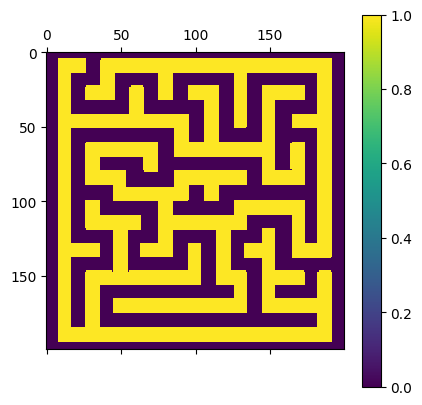

In [2]:
# Load the image and convert to grayscale
image_path = "../data/map2.png"
image = Image.open(image_path).convert("L")

# Convert image data to numpy array and normalize
grid_map = np.array(image.getdata()).reshape(image.size[1], image.size[0]) / 255

# Binarize the image: convert to binary values (0 for free space, 1 for obstacles)
threshold = 0.5  # Adjust threshold if needed
grid_map[grid_map > threshold] = 1
grid_map[grid_map <= threshold] = 0

# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1

# Flip x and y coords for start and goal
q_start = Point(8, 31)
q_goal = Point(139, 38)

# Build C space
C = []
for i, row in enumerate(grid_map):
    for j, cell in enumerate(row):
        if cell == 0:
            C.append([i, j])


# Visualize the grid map
plt.matshow(grid_map)
plt.colorbar()
plt.show()

In [3]:
def rand_config(grid_map, p, q_goal):
    # Return goal with probability p, otherwise sample random point
    if np.random.rand() < p:
        return q_goal
    else:
        # generate random coordinats within the grid bounds
        x = np.random.uniform(0, grid_map.shape[0] - 1)
        y = np.random.uniform(0, grid_map.shape[1] - 1)
        # Return a Point object with the random coordinates
        return Point(x, y)

def nearest_vertex(q_rand, G):
    # Find the vertex in G closest to q_rand
    vertices = G["vertices"]
    smallest_distance = float('inf')
    nearest_vertex = None
    # for each vertex in the graph
    for vertex in vertices:
        distance = q_rand.dist(vertex) # calculate the distance from q_rand to the current vertex
        if distance < smallest_distance: # is distance smaller than the smallest distance found so far
            smallest_distance = distance # update the smallest distance
            nearest_vertex = vertex   #Update the nearest vertex
   
    return nearest_vertex

def new_config(q_near, q_rand, delta_q):
    # Move from q_near towards q_rand by delta_q
    delta_x = q_rand.x - q_near.x
    delta_y = q_rand.y - q_near.y
    distance = q_near.dist(q_rand) # calculate the distance between q_near and q_rand
    if distance == 0: # If it iis zero, return q_near
        return q_near
    # normalize the direction vector 
    direction = [delta_x / distance, delta_y / distance]
    move_x = direction[0] * delta_q
    move_y = direction[1] * delta_q
    new_x = round(q_near.x + move_x)
    new_y = round(q_near.y + move_y)
    # add a new Point object with the new coordinates
    q_new = Point(new_x, new_y)
    # check if the new point overshoot the target
    if q_near.dist(q_new) > distance:  # if yes, set q_new to be the same as q_rand
        q_new = Point(q_rand.x, q_rand.y)
    return q_new

def is_segment_free_inc(q_near, q_new, C):
    # Check if segment between q_near and q_new is free from obstacles
    num_samples = int(max(abs(q_new.x - q_near.x), abs(q_new.y - q_near.y)) + 1)
    # Generate evenly spaced coordinates between q_near and q_new
    x_coords = np.linspace(q_near.x, q_new.x, num_samples).astype(int)
    y_coords = np.linspace(q_near.y, q_new.y, num_samples).astype(int)
    for x, y in zip(x_coords, y_coords):
        
        if [x, y] not in C: # Is the current point in the obstacle-free list C
            return False # collision
    # all points are obstacle-free
    return True

def add_vertex(G, vertex):
    # Append the new vertex to the graph's vertex list
    G["vertices"].append(vertex)

def add_edge(G, vertex_1, vertex_2):
    # Append the new edge to the graph's edge list
    G["edges"].append((vertex_1, vertex_2))


In [4]:
def fill_path(vertices, edges, q_goal):
    if not edges:
        return vertices, edges, []
    path = []
    start_v= vertices[0]
    goal_v = None
    # Find the goal vertex
    for edge in edges:
        if edge[1] == q_goal:
            goal_v = q_goal
            break

    if goal_v is None:
        return vertices, edges, []  # goal not found

    parent = {edge[1]: edge[0] for edge in edges}
    current = goal_v
    while current != start_v:
        path.append(current)
        if current in parent:
            current = parent[current]
        else:
            return vertices, edges, []  # path is incomplete, exit early

    path.append(start_v)
    path.reverse()
    return vertices, edges, path

def path_distance(path):
    # calculate the total distance of the path
    path_distance = 0
    for i in range(1, len(path)):
        path_distance += path[i - 1].dist(path[i])
    path_distance = round(path_distance, 2) 
    return path_distance

def plot_RRT_star(grid_map, vertices, edges, q_start, q_goal, path=None):
    plt.figure(figsize=(10, 10))
    plt.matshow(grid_map, fignum=0)

    for edge in edges:
        vertex_1, vertex_2 = edge
        x_coords = [vertex_1.y, vertex_2.y]
        y_coords = [vertex_1.x, vertex_2.x]
        plt.plot(x_coords, y_coords, 'w-')

    plt.plot(q_start.y, q_start.x, "r*")
    plt.plot(q_goal.y, q_goal.x, "g*")

    if path:
        for i in range(len(path) - 1):
            plt.plot([path[i].y, path[i + 1].y], [path[i].x, path[i + 1].x], color='red')

    plt.show()

In [5]:
def RRT_star(grid_map, C, K, delta_q, p, q_start, q_goal, r):
    G = {
        "vertices": [q_start],
        "edges": []
    }

    cost = {q_start: 0}
    min_dist = 1
    initial_solution_found = False
    initial_solution_path = []

    for k in range(1, K):
        q_rand = rand_config(grid_map, p, q_goal)  
        q_near = nearest_vertex(q_rand, G)
        q_new = new_config(q_near, q_rand, delta_q)

        if is_segment_free_inc(q_near, q_new, C):  
            neighbours = [v for v in G["vertices"] if v.dist(q_new) <= r]   # find all vertices within a radius r of q_new
            q_min = q_near
            cost[q_new] = float('inf')

            for n in neighbours:           # through each neighbour, evaluate the cost to reach q_new 
                if is_segment_free_inc(n, q_new,C):  # Check for collisions
                    if cost[n] + n.dist(q_new) < cost[q_new]:     # check of n has lower cost 
                        q_min = n
                        cost[q_new] = cost[n] + n.dist(q_new)

            add_vertex(G, q_new)  
            add_edge(G, q_min, q_new)
            # Rewire the neighbors
            for n in neighbours:
                if is_segment_free_inc(n, q_new,C):
                    if cost[q_new] + q_new.dist(n) < cost[n]:
                        cost[n] = cost[q_new] + q_new.dist(n)
                        G["edges"] = [edge for edge in G["edges"] if edge[1] != n]     # remove the existing edge and add the new one
                        add_edge(G, q_new, n)
                        #print(f"Updated cost for q_new: {q_new}, new cost: {cost[q_new]}, parent: {q_min}")
            if q_new.dist(q_goal) < min_dist:
                if is_segment_free_inc(q_new, q_goal, C):
                    add_vertex(G, q_goal)
                    add_edge(G, q_new, q_goal)
                    cost[q_goal] = cost[q_new] + q_new.dist(q_goal)
                    if not initial_solution_found:
                        #  store the path when the initial solution is found
                        initial_solution_found = True
                        _, _, initial_solution_path = fill_path(G["vertices"], G["edges"], q_goal)
                        initial_distance = path_distance(initial_solution_path)
                        plot_RRT_star(grid_map, G["vertices"], G["edges"], q_start, q_goal, initial_solution_path)
                        print(f"Initial path distance: {initial_distance}")
                        print("Initial path:")
                        print([(p.x, p.y) for p in initial_solution_path]) 
          
    final_solution_path = []
    if q_goal in cost:
        _, _, final_solution_path = fill_path(G["vertices"], G["edges"], q_goal)
    #_, _, final_solution_path = fill_path(G["vertices"], G["edges"]) if q_goal in cost else ([],[],[])
    return G, cost, initial_solution_path, final_solution_path

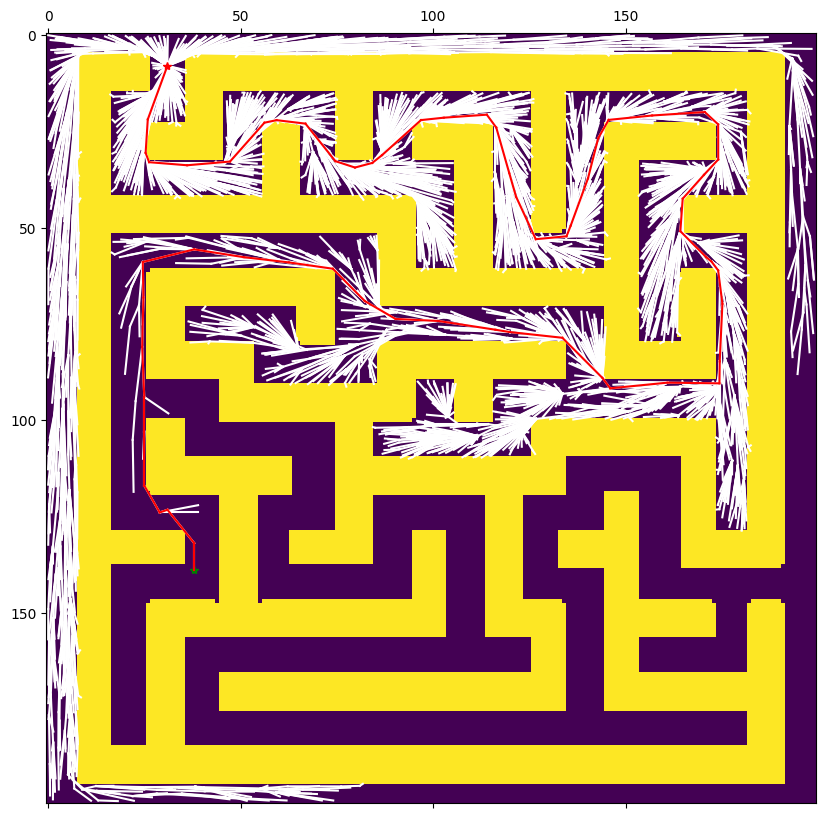

Initial path distance: 555.72
Initial path:
[(8, 31), (21.908809069813884, 25.911625034244224), (30.6044070310179, 25.351868379073814), (33.01895645378742, 26.257021190649812), (33.81770884375576, 36.13616535596966), (32.84886648674377, 47.27028451140591), (22.76131366247037, 56.210314541016324), (22.10438204280639, 59.36845910553862), (23.004159048463066, 66.86434449509711), (32.743510525055456, 74.63156858371373), (34.4090690697487, 79.72399506313333), (33.210067068285596, 84.22368650755422), (31.2034194978142, 86.73807189238387), (22.08554510073068, 96.87260085179626), (21.464333665231983, 102.78818639207022), (20.6783208533964, 113.97223963910888), (24.035109911392354, 116.43163121067211), (35.82023878992558, 119.78910157629691), (41.97654496236146, 121.56504351386913), (53.019200071126114, 126.6950667819724), (52.26751880623869, 134.67559502248736), (49.48884334671463, 135.76103302134783), (37.242501474765206, 140.24434905244325), (26.770915510933854, 142.9066824130566), (22.03358

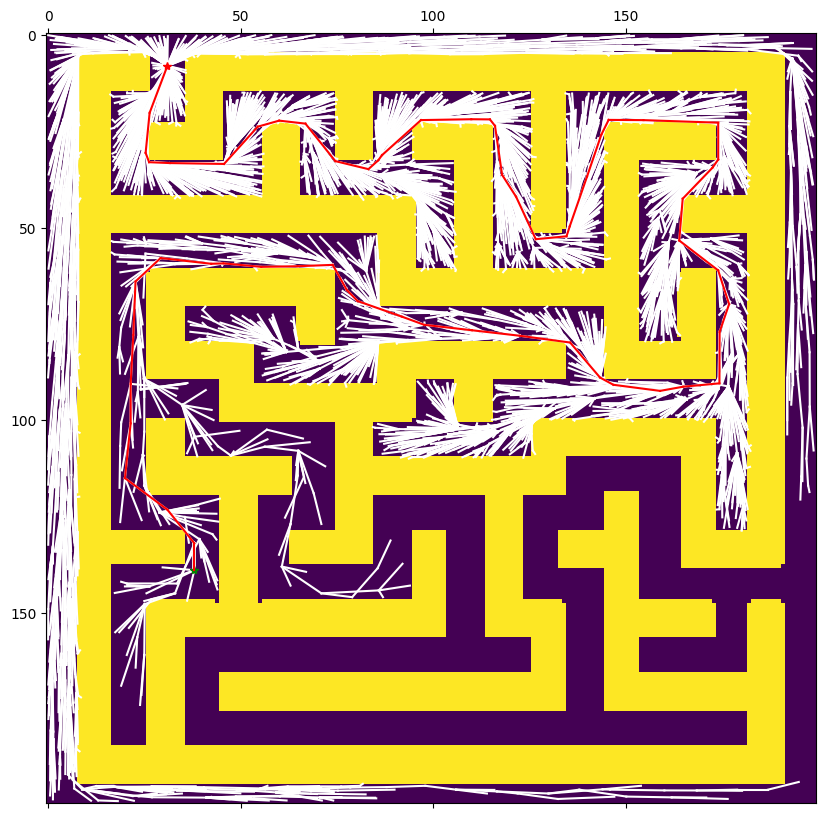

Final path distance: 557.48
Final path:
[(8, 31), (20.20721573930192, 26.389087304300773), (30.6044070310179, 25.351868379073814), (33.01895645378742, 26.257021190649812), (33.2469001635442, 31.64588315088699), (33.47782626112284, 45.71998337555005), (23.796857165386264, 54.47662993639248), (22.226283349804316, 60.038130597231344), (23.004159048463066, 66.86434449509711), (32.743510525055456, 74.63156858371373), (34.82703619803521, 83.22393121979106), (32.50798195214544, 85.78888685299134), (31.2034194978142, 86.73807189238387), (22.08554510073068, 96.87260085179626), (21.86331810057919, 109.93953043246307), (21.90227045377395, 114.77859567635927), (23.586388076817197, 116.0950486572832), (36.28808673908867, 117.93168988691285), (41.97654496236146, 121.56504351386913), (53.019200071126114, 126.6950667819724), (52.26751880623869, 134.67559502248736), (49.65739733398095, 135.5155047723126), (36.73163827484384, 140.00854834538086), (25.883115187563934, 143.71092272086395), (22.03358089752

In [6]:

G, cost, initial_solution_path, final_solution_path = RRT_star(grid_map, C, 30000, 8, 0.2, q_start, q_goal, 15)
vertices = G["vertices"]
edges = G["edges"]

# Declare if no initial solution found
if not initial_solution_path:
    print("No initial solution found.")

# Visualize the final solution
if final_solution_path:
    final_distance = path_distance(final_solution_path)
    plot_RRT_star(grid_map, vertices, edges, q_start, q_goal, final_solution_path)
    print(f"Final path distance: {final_distance}")
    print("Final path:")
    print([(p.x, p.y) for p in final_solution_path])
else:
    print("No final solution found.")